# Predictive Analysis: ANZ Synthesized 3-month Transactional Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg
from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from sklearn.decomposition import PCA

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Background

Source: https://www.theforage.com/modules/ZLJCsrpkHo9pZBJNY/BiJPfqmGY2QwgN6gA

This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions. The dataset is designed to simulate realistic transaction behaviours that are observed in ANZ’s real transaction data, so many of the insights gathered from the activities will be genuine.

## Step 0: Load the dataset and perform EDA

### Overview
The aim of this dataset is to try to understand the features of purchasing behaviour of customers (independent variables) for modelling expected values for annualized salary (dependent variable)

In [2]:
# referencing the cleaned dataset
file = 'DATA/ANZ-synthesized-transactions-cleaned.csv'
# Read file and parse timestamp as the index
df = pd.read_csv(file)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          12043 non-null  object 
 1   status             12043 non-null  object 
 2   card_present_flag  6194 non-null   float64
 3   account            12043 non-null  int64  
 4   first_name         12043 non-null  object 
 5   age                12043 non-null  int64  
 6   gender             12043 non-null  object 
 7   txn_description    12043 non-null  object 
 8   balance            12043 non-null  float64
 9   amount             12043 non-null  float64
 10  geometry           12043 non-null  object 
 11  X                  12043 non-null  float64
 12  Y                  12043 non-null  float64
 13  merch_suburb       7717 non-null   object 
 14  merch_state        7717 non-null   object 
 15  merch_geometry     7717 non-null   object 
 16  merch_X            771

In [4]:
df.isnull().sum()

timestamp               0
status                  0
card_present_flag    5849
account                 0
first_name              0
age                     0
gender                  0
txn_description         0
balance                 0
amount                  0
geometry                0
X                       0
Y                       0
merch_suburb         4326
merch_state          4326
merch_geometry       4326
merch_X              4326
merch_Y              4326
distance             4334
country                 0
card_present_bool       0
dtype: int64

In [5]:
# Check the distinct values for each column
df.nunique()

timestamp             9231
status                   2
card_present_flag        1
account                100
first_name              80
age                     33
gender                   2
txn_description          6
balance              11920
amount                3980
geometry               100
X                       85
Y                       87
merch_suburb          1609
merch_state              8
merch_geometry        2674
merch_X                647
merch_Y                690
distance              3967
country                  1
card_present_bool        2
dtype: int64

In [6]:
df.head()

,timestamp,status,card_present_flag,account,first_name,age,gender,txn_description,balance,amount,...,X,Y,merch_suburb,merch_state,merch_geometry,merch_X,merch_Y,distance,country,card_present_bool
0,218-8-1 1:1:15+:,authorized,1.0,159845171,Diana,26,F,POS,35.39,16.25,...,-27.95,153.41,Ashmore,QLD,153.38 -27.99,-27.99,153.38,5.34,Australia,True
1,218-8-1 1:13:45+:,authorized,NaN,159845171,Diana,26,F,SALES-POS,21.20,14.19,...,-27.95,153.41,Sydney,NSW,151.21 -33.87,-33.87,151.21,691.63,Australia,False
2,218-8-1 1:26:15+:,authorized,1.0,12223524,Michael,38,M,POS,5.71,6.42,...,-33.94,151.23,Sydney,NSW,151.21 -33.87,-33.87,151.21,8.10,Australia,True
3,218-8-1 1:38:45+:,authorized,1.0,1375564,Rhonda,4,F,SALES-POS,2117.22,4.90,...,-27.66,153.10,Buderim,QLD,153.5 -26.68,-26.68,153.50,19.20,Australia,True
4,218-8-1 1:51:15+:,authorized,1.0,159845171,Diana,26,F,SALES-POS,17.95,3.25,...,-27.95,153.41,Mermaid Beach,QLD,153.44 -28.6,-28.60,153.44,12.60,Australia,True


In [7]:
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [8]:
df.gender.value_counts()

M    6285
F    5758
Name: gender, dtype: int64

In [9]:
df.merch_state.value_counts()

NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merch_state, dtype: int64

In [10]:
df_sns = df

<AxesSubplot:xlabel='merch_state', ylabel='amount'>

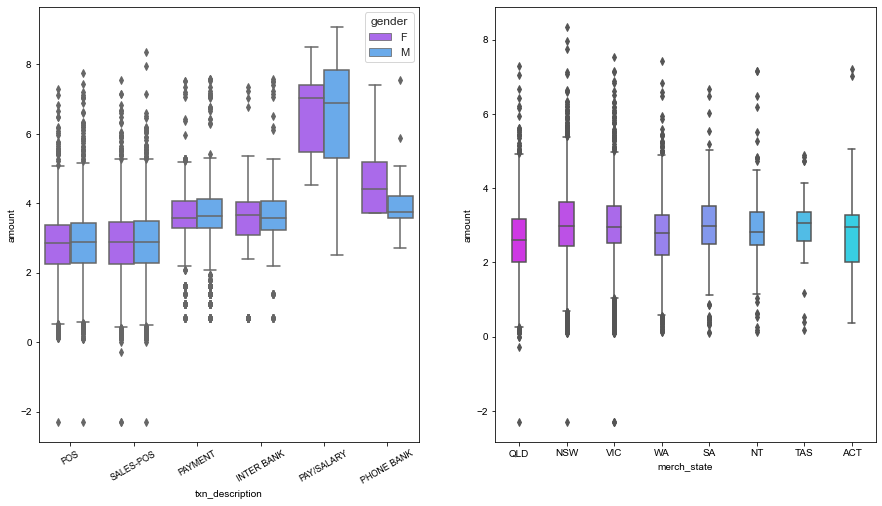

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.set_theme(style='whitegrid')
sns.boxplot(ax=ax[0], x='txn_description', y=np.log(df.amount), hue='gender', data=df_sns, palette="cool_r")
ax[0].set_xticklabels(ax[0].get_xticklabels(), size=9, rotation=30)
sns.boxplot(ax=ax[1], x='merch_state', y=np.log(df.amount), data=df_sns, palette="cool_r", width=0.3)

In [12]:
df_state_cat = df.groupby(['account', 'merch_state']).size().unstack(fill_value=0)

In [13]:
assert np.sum(df_state_cat[['ACT', 'NSW', 'NT', 'QLD', 'SA', 'TAS', 'VIC', 'WA']].sum(axis=1) != 0) \
            == len(df.groupby('account')), 'If dataframe is indexed on customer accounts, \
            then there will be no missing values for merchant information'

#### a) Drop irrelevant features

In [14]:
if ('status' or 'card_present_flag' or 'first_name' or 'country' or 'timestamp' \
    or 'geometry' or 'merch_suburb' or 'distance' or 'merch_geometry' or 'card_present_bool') in df:
    df = df.drop(columns=['status', 'card_present_flag', 'first_name','country', 
                        'timestamp', 'geometry', 'merch_suburb', 'distance',
                        'merch_geometry', 'card_present_bool'])

#### b) Conduct Feature engineering

In [15]:
def geocoder(data):
    '''
    input: dataframe containing Latitude(x) and Longitude(y) coordinates
    output: JSON data containing info on available building or street names.
    '''
    coordinates = list(zip(data.X, data.Y))
    results = rg.search(coordinates) # default mode = 2
    return results

list_1 = geocoder(df)

Loading formatted geocoded file...


In [16]:
df_geocodes = pd.DataFrame.from_dict(list_1)

In [17]:
df_geocodes.head()

,lat,lon,name,admin1,admin2,cc
0,-27.96724,153.39796,Southport,Queensland,Gold Coast,AU
1,-27.96724,153.39796,Southport,Queensland,Gold Coast,AU
2,-33.93333,151.23333,Daceyville,New South Wales,Randwick,AU
3,-27.63917,153.10944,Logan City,Queensland,Logan,AU
4,-27.96724,153.39796,Southport,Queensland,Gold Coast,AU


In [18]:
df_geocodes.nunique()

lat       83
lon       85
name      87
admin1    11
admin2    60
cc         6
dtype: int64

In [19]:
df_geocodes.cc.value_counts()

AU    10513
ZA      830
AO      368
ID      134
AQ      123
NA       75
Name: cc, dtype: int64

* AU = Australia
* ZA = South Africa
* AO = Angola
* ID = Indonesia
* AQ = Antartica
* NA = Namibia

In [20]:
df_geocodes.admin1.value_counts()

Victoria             3716
Queensland           2360
New South Wales      1835
Western Australia    1716
Western Cape          830
South Australia       798
Benguela              368
Sulawesi Tenggara     134
                      123
Tasmania               88
Erongo                 75
Name: admin1, dtype: int64

In [21]:
check_null = df_geocodes.isnull().sum()

In [22]:
check_null

lat       0
lon       0
name      0
admin1    0
admin2    0
cc        0
dtype: int64

In [23]:
df_geocodes[~df_geocodes.admin1.str.contains('\w')].admin1.count()

123

In [24]:
df_geocodes.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [25]:
df_geocodes.isnull().sum()

lat         0
lon         0
name        0
admin1    123
admin2    973
cc          0
dtype: int64

In [26]:
df['cust_state'] = df_geocodes['admin1']
df['cc'] = df_geocodes['cc']

In [27]:
# get dummy variables
df = pd.get_dummies(data=df, columns=['gender', 'txn_description', 'merch_state', 'cust_state', 'cc'], 
                    prefix=['g', 't', 'm', 'c', 'cc'], drop_first=True)

In [28]:
# feature engineer from coordinates X and Y
x = df.X
y = df.Y

 **Source:** https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796

In [29]:
# geospatial feature engineering trick 1: Add 4 new features of Polar coordinates to the dataset
df['r'] = np.sqrt(x**2 + y**2)
df['phi'] = np.arctan2(y, x)
df['rot_x'] = np.cos(x) + np.sin(x)
df['rot_y'] = np.sin(x) - np.sin(y)

In [30]:
# geospatial feature engineering trick 2: Add 4 new features of rotational Cartesian coordinates

df['rot_45_x'] = (0.707 * x) + (0.707 * y)
df['rot_45_y'] = (0.707 * y) + (0.707 * x)
df['rot_30_x'] = (0.866 * x) + (0.5 * y)
df['rot_30_y'] = (0.866 * y) + (0.5 * x)

In [31]:
# geospatial feature engineering trick 3: Add new feature of Haversine distance to the dataset
x_1 = df.merch_X
y_1 = df.merch_Y

def haversine_dist(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

df['h_dist'] = haversine_dist(x, y, x_1, y_1)

In [32]:
def manhattan_dist(lat1, lng1, lat2, lng2):
    '''
    calculating two haversine distances by,
     - avoiding Latitude of one point 
     - avoiding Longitude of one point
    and adding it together.
    '''
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a + b

df['m_dist'] = manhattan_dist(x, y, x_1, y_1)

In [33]:
def bearing_degree(lat1, lng1, lat2, lng2):
    '''
    calculate angle between two points
    '''
    radius = 6371  # Mean radius of Earth
    diff_lng = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(diff_lng) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(diff_lng)
    return np.degrees(np.arctan2(y, x))

df['b_deg'] = bearing_degree(x, y, x_1, y_1)

In [34]:
def pca(data):
    '''
    input: dataframe containing Latitude(x) and Longitude(y)
    '''
    coordinates = data[['X','Y']].values
    pca_obj = PCA(random_state=42).fit(coordinates)
    pca_x = pca_obj.transform(data[['X', 'Y']])[:,0]
    pca_y = pca_obj.transform(data[['X', 'Y']])[:,1]
    return pca_x, pca_y

df['pca_x'], df['pca_y'] = pca(df)

In [35]:
df.drop(columns=['X', 'Y', 'merch_X', 'merch_Y'], inplace=True)

In [36]:
df = df.rename(columns={'account': 'acc', 'balance': 'bal', 'amount': 'amt','t_PAY/SALARY': 't_pay', 't_PAYMENT': 't_pmt', 
                        't_PHONE BANK': 't_phb', 't_POS': 't_pos', 't_SALES-POS': 't_sales', 'c_Erongo': 'c_ER', 
                        'c_New South Wales': 'c_NSW', 'c_Queensland': 'c_QLD', 'c_South Australia': 'c_SA', 
                        'c_Sulawesi Tenggara': 'c_SULTRA', 'c_Tasmania': 'c_TAS', 'c_Victoria': 'c_VIC', 
                        'c_Western Australia': 'c_WA', 'c_Western Cape': 'c_WC'})

In [37]:
if '_NSW' not in df: 
    df['_NSW'] = df['c_NSW'] + df['m_NSW']
    df.drop(columns=['c_NSW', 'm_NSW'], inplace=True)
if '_QLD' not in df:
    df['_QLD'] = df['c_QLD'] + df['m_QLD']
    df.drop(columns=['c_QLD', 'm_QLD'], inplace=True)
if '_SA' not in df:
    df['_SA'] = df['c_SA'] + df['m_SA']
    df.drop(columns=['c_SA', 'm_SA'], inplace=True)
if '_TAS' not in df:
    df['_TAS'] = df['c_TAS'] + df['m_TAS']
    df.drop(columns=['c_TAS', 'm_TAS'], inplace=True)
if '_VIC' not in df:
    df['_VIC'] = df['c_VIC'] + df['m_VIC']
    df.drop(columns=['c_VIC', 'm_VIC'], inplace=True)
if '_WA' not in df:
    df['_WA'] = df['c_WA'] + df['m_WA']
    df.drop(columns=['c_WA', 'm_WA'], inplace=True)

In [38]:
df.columns

Index(['acc', 'age', 'bal', 'amt', 'g_M', 't_pay', 't_pmt', 't_phb', 't_pos',
       't_sales', 'm_NT', 'c_ER', 'c_SULTRA', 'c_WC', 'cc_AQ', 'cc_AU',
       'cc_ID', 'cc_NA', 'cc_ZA', 'r', 'phi', 'rot_x', 'rot_y', 'rot_45_x',
       'rot_45_y', 'rot_30_x', 'rot_30_y', 'h_dist', 'm_dist', 'b_deg',
       'pca_x', 'pca_y', '_NSW', '_QLD', '_SA', '_TAS', '_VIC', '_WA'],
      dtype='object')

## Step 1: Identify annual salary of each customer

### a) Subset Pay/Salary transactions and group by account

In [39]:
# display counts of payment types
total_sal = df.amt[df.t_pay == 1].groupby(df.acc).sum()
annual_sal = total_sal * 4
annual_sal = annual_sal.sort_values()

In [40]:
df = df.groupby('acc').mean()
df['a_sal'] = annual_sal

In [41]:
df.head()

,age,bal,amt,g_M,t_pay,t_pmt,t_phb,t_pos,t_sales,m_NT,...,b_deg,pca_x,pca_y,_NSW,_QLD,_SA,_TAS,_VIC,_WA,a_sal
acc,,,,,,,,,,,,,,,,,,,,,
958567,34,4736.124598,205.593678,0.0,0.040230,0.281609,0.000000,0.350575,0.293103,0.505747,...,17.327454,-74.407257,92.714269,0.074713,0.017241,0.000000,0.0,0.028736,0.017241,98493.08
1375564,4,2510.007683,71.145444,0.0,0.050193,0.100386,0.000000,0.428571,0.420849,0.000000,...,3.089790,1.077052,-25.237176,0.061776,1.714286,0.000000,0.0,0.046332,0.027027,46430.80
1566392,22,31965.638605,256.383837,1.0,0.069767,0.069767,0.000000,0.267442,0.406977,0.000000,...,-56.868299,6.800156,-13.698173,0.023256,0.000000,0.034884,0.0,1.616279,0.000000,76682.40
2484743,29,10137.490448,60.019776,1.0,0.052239,0.350746,0.097015,0.223881,0.276119,0.000000,...,-2.797769,-34.383113,-7.514613,0.164179,0.082090,0.007463,0.0,0.007463,0.231343,12468.40
2615387,43,20212.127500,208.970000,0.0,0.250000,0.096154,0.000000,0.192308,0.211538,0.000000,...,-23.538861,7.171829,-13.569880,0.019231,0.019231,0.000000,0.0,1.365385,0.000000,34550.36


In [42]:
df.describe()

,age,bal,amt,g_M,t_pay,t_pmt,t_phb,t_pos,t_sales,m_NT,...,b_deg,pca_x,pca_y,_NSW,_QLD,_SA,_TAS,_VIC,_WA,a_sal
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,27.360000,11297.004375,178.540553,0.560000,0.094944,0.248644,0.010218,0.283731,0.293591,0.013084,...,2.495377,0.162950,0.822367,0.344627,0.206924,0.105087,0.015562,0.547653,0.207054,46042.555200
std,15.220613,20898.005949,135.687430,0.498888,0.066505,0.159644,0.035562,0.101519,0.107645,0.084313,...,63.675489,57.999291,38.361108,0.516759,0.502226,0.322547,0.116942,0.697151,0.477177,37267.210968
min,2.000000,911.712805,21.284827,0.000000,0.008368,0.017241,0.000000,0.016667,0.000000,0.000000,...,-104.271455,-74.407257,-26.033951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,600.000000
25%,19.000000,3611.222550,62.012350,0.000000,0.049485,0.127563,0.000000,0.215734,0.227860,0.000000,...,-53.337000,-10.970033,-20.767472,0.030888,0.000000,0.000000,0.000000,0.017080,0.000000,9150.720000
50%,26.000000,4729.864282,154.624111,1.000000,0.075000,0.212160,0.000000,0.299985,0.299878,0.000000,...,-3.997167,5.756018,-13.500609,0.093842,0.012862,0.012500,0.000000,0.032002,0.014806,44119.680000
75%,38.000000,8869.689363,256.139616,1.000000,0.118453,0.347302,0.000000,0.359231,0.369232,0.000000,...,57.547109,6.519173,-3.286728,0.383395,0.031024,0.030365,0.000000,1.372198,0.051994,69963.530000
max,78.000000,173721.982687,685.794194,1.000000,0.352941,0.773810,0.285714,0.508251,0.534483,0.674847,...,135.376143,534.986414,125.494767,1.749175,1.768166,1.326087,1.159091,1.695035,1.654110,141375.680000


## Step 2: Feature selection and data splitting

In [43]:
X = df[list(set(df.columns) - set(df[['a_sal']]))]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
y = df.a_sal

<AxesSubplot:>

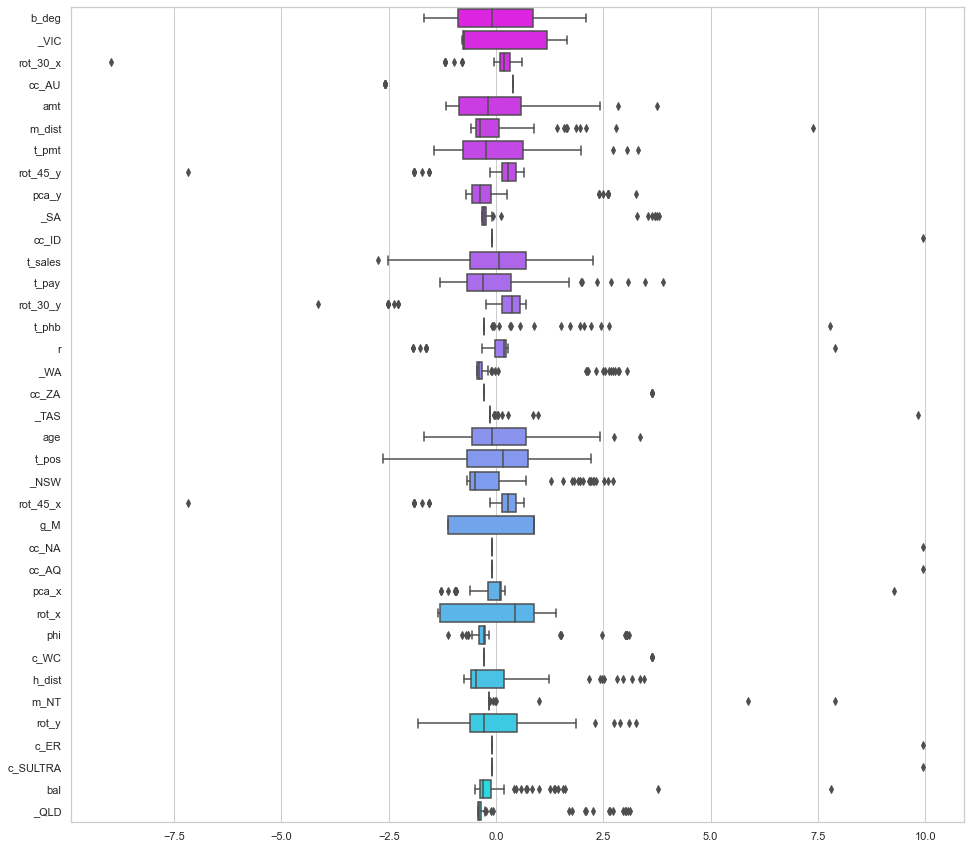

In [44]:
fig, ax = plt.subplots(figsize=(16, 15))
sns.boxplot(data=X, orient='h', palette="cool_r")

Wall time: 833 ms


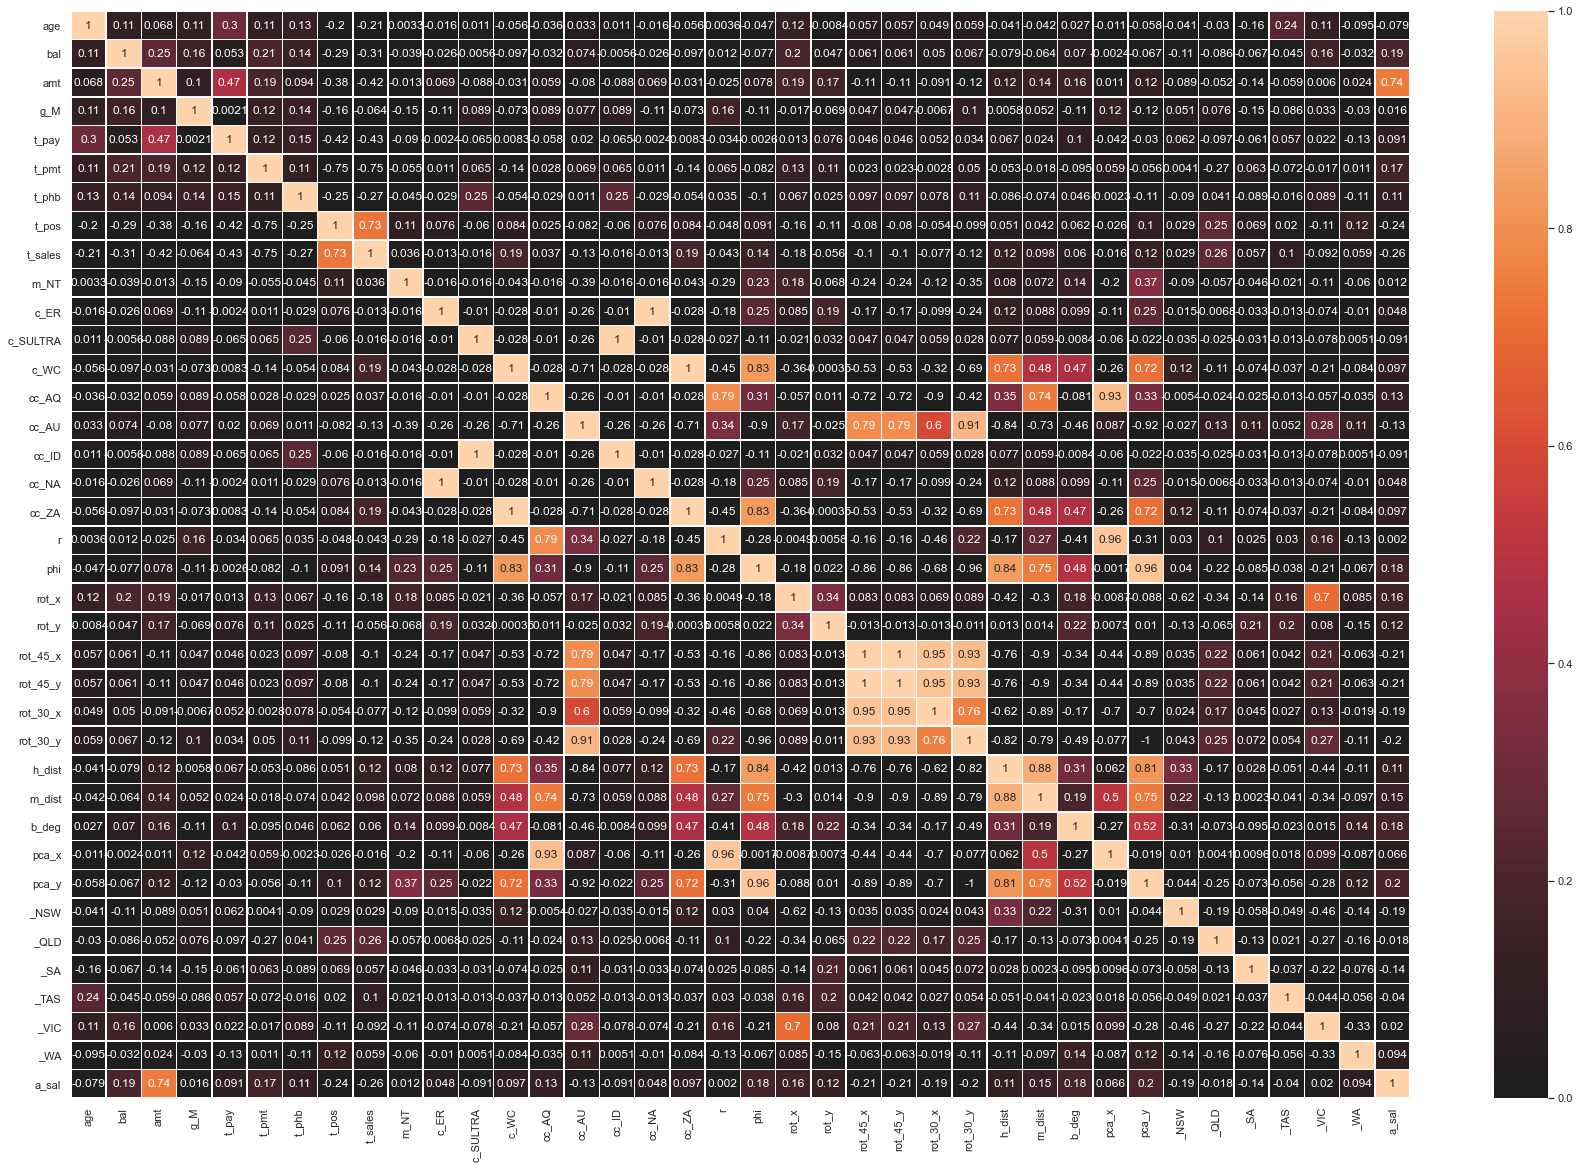

In [45]:
%%time
fig, ax = plt.subplots(figsize=(30,20))
_ = sns.heatmap(df.corr(), vmin=0, vmax=1, center=0, ax=ax, annot=True, linewidths=.5)

## Step 3: Build linear regression model to predict annual salary

### b) Linear Regression Model

In [46]:
reg = LinearRegression()

In [47]:
# split data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [48]:
%%time
reg.fit(X_train, y_train)

Wall time: 3 ms


LinearRegression()

In [49]:
reg.score(X_test, y_test)

0.08083812254737299

In [50]:
def view_coeff(X, model):
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': model.coef_,
                                'abs_coef': np.abs(model.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    sns.barplot(x="variable", y="coef", data=model_coefs, )

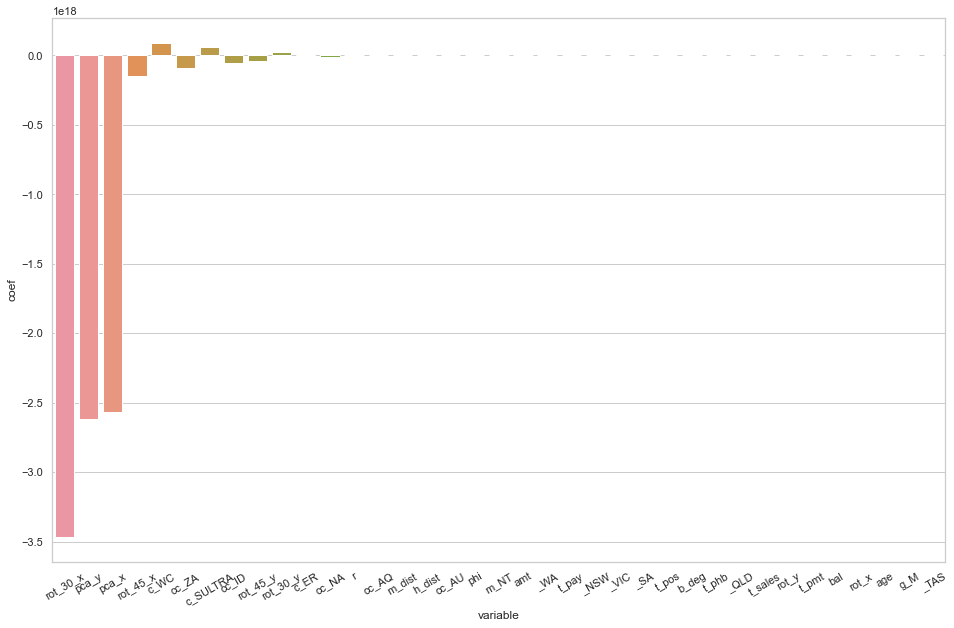

In [51]:
# Plot Coefficients
fig, ax = plt.subplots(figsize=(16,10))
view_coeff(X, reg)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


* Linear regression tends to only work on low dimensional datasets. From the plot above it is clear that the linear model is influenced by outliers.

In [52]:
# Remove outliers to see whether it improves accuracy
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [53]:
X = df[list(set(df.columns) - set(df[['a_sal']]))]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
y = df.a_sal

In [54]:
# split data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [55]:
%%time
reg.fit(X_train, y_train)

Wall time: 2 ms


LinearRegression()

In [56]:
reg.score(X_test, y_test)

0.5904497079276592

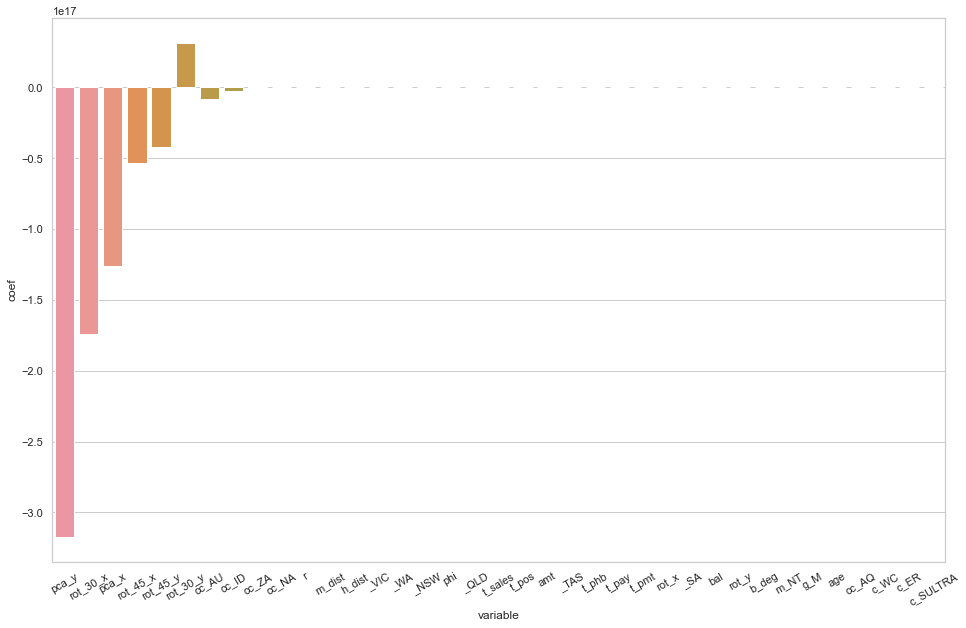

In [57]:
# Plot Coefficients
fig, ax = plt.subplots(figsize=(16,10))
view_coeff(X, reg)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

* Therefore, removing outliers does improve accuracy. However, that accuracy score is a very low baseline. We should try to improve our accuracy by using other models and foward feature selection

### d) Ridge Regression alpha optimization - L2

In [58]:
%%time
## Calculate Ridge Regression model

# create a model object to hold the modelling parameters
clf = Ridge()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
ridge_alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in ridge_alphas:
    clf.set_params(alpha = a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
    errors.append(mean_squared_error(clf.coef_, reg.coef_))

Wall time: 520 ms


In [59]:
%%time
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)
print('Alpha:', optimal_ridge.alpha_)
print('Score:', optimal_ridge.score(X, y))

Alpha: 30.01835813575586
Score: 0.7012507335068642
Wall time: 9.55 s


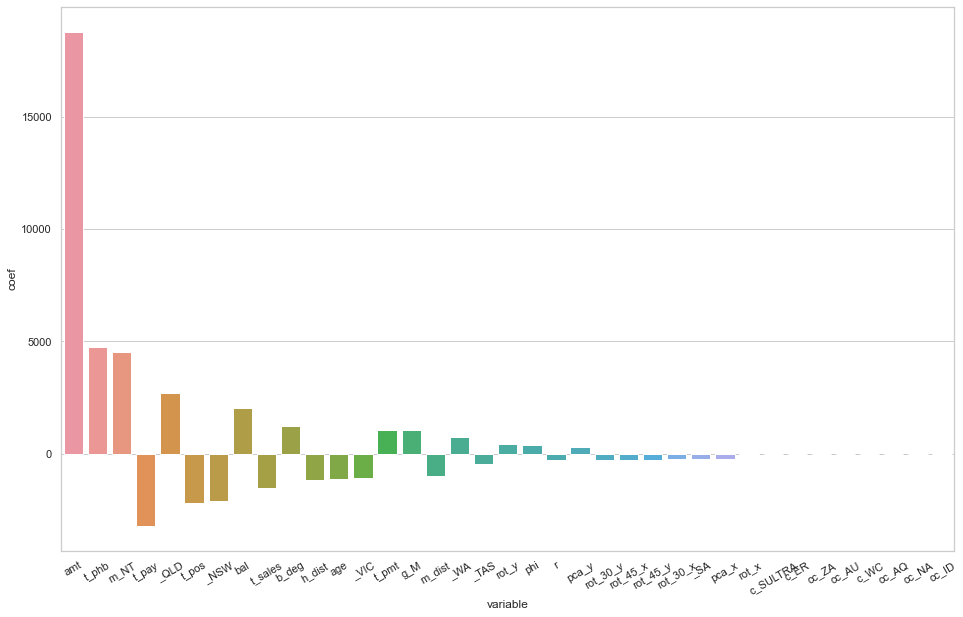

In [60]:
fig, ax = plt.subplots(figsize=(16,10))
view_coeff(X, optimal_ridge)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### d) Lasso Regression alpha optimization - L1

In [61]:
%%time
## Calculate Lasso Regression model

# create a model object to hold the modelling parameters
clf = Lasso()
# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
lasso_alphas = np.logspace(-6, 6, 200)
# Train the model with different regularisation strengths
for a in lasso_alphas:
    clf.set_params(alpha = a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
    errors.append(mean_squared_error(clf.coef_, reg.coef_))

Wall time: 804 ms


In [62]:
%%time
# Find Optimal Lasso Using LassoCV
optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10)
optimal_lasso.fit(X, y)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', optimal_lasso.score(X, y))

Alpha: 3370.0643292719246
Score: 0.7308220221122853
Wall time: 3.44 s


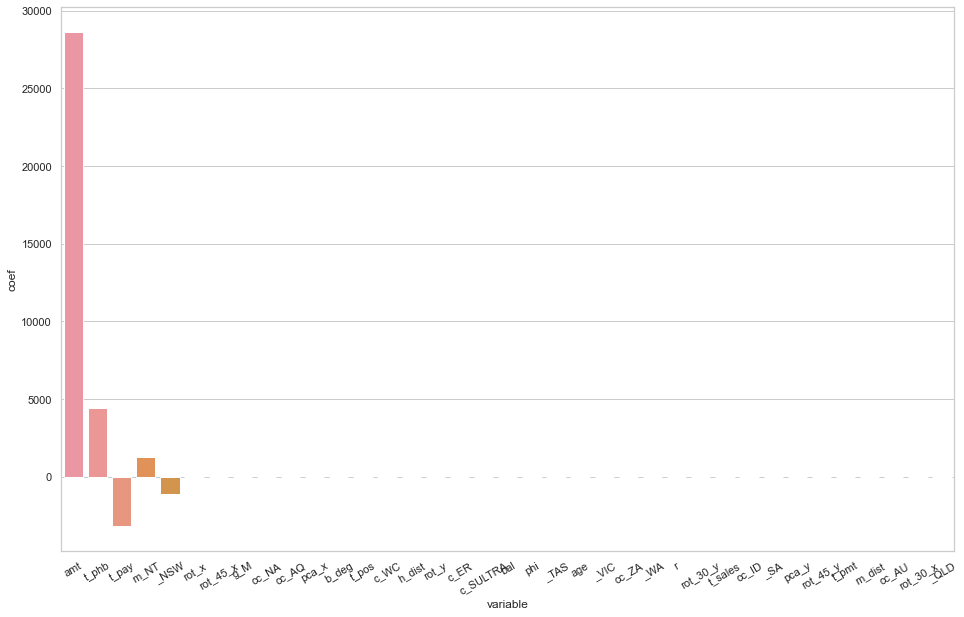

In [63]:
# Plot Coefficient
fig, ax = plt.subplots(figsize=(16,10))
view_coeff(X, optimal_lasso)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [64]:
## Flag intermediate output

show_steps = False   # for testing/debugging
# show_steps = False  # without showing steps

In [65]:
%%time
## Use Forward Feature Selection to pick a good model

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LinearRegression()
# get the number of cases in the test data
n = X_test.shape[0]

r2_list = []
adjusted_r2_list = []

while True:
    changed = False
    
    if show_steps:
        print('') 

    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    if show_steps:
        print('(Step) Excluded = %s' % ', '.join(excluded))  

    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))

        # fit the model with the Training data
        fit = model.fit(X_train[included + [new_column]], y_train)
        # calculate the score (R^2 for Regression)
        r2 = fit.score(X_train[included + [new_column]], y_train)
        
        # number of predictors in this model
        k = len(included) + 1
        # calculate the adjusted R^2
        adjusted_r2 = 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )
        
        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    # END for
    
    r2_list.append(best['r2'])
    adjusted_r2_list.append(best['a_r2'])

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        print('*'*50)
        break

print('')
print('Resulting features:')
print(', '.join(included))

Added feature amt  with R^2 = 0.670 and adjusted R^2 = 0.651
Added feature t_phb with R^2 = 0.714 and adjusted R^2 = 0.680
Added feature m_NT with R^2 = 0.745 and adjusted R^2 = 0.697
**************************************************

Resulting features:
amt, t_phb, m_NT
Wall time: 522 ms


### Retrain model with only foward selected features

In [66]:
X = df[['amt', 't_phb', 'm_NT']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
y = df.a_sal

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [68]:
%%time
reg.fit(X_train, y_train)

Wall time: 1.99 ms


LinearRegression()

In [69]:
reg.score(X_test, y_test)

0.5846881144141078

### Decision tree model

In [70]:
param_grid = {'splitter': ['best', 'random'],
              'max_depth' : [1,3,5,7,9,11,12],
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
              'max_features':['auto','log2','sqrt',None],
              'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90] }
reg = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)

In [71]:
%%time
# Fit the model
reg.fit(X_train, y_train)

Wall time: 1min 31s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']})

In [72]:
reg = reg.best_estimator_

In [73]:
reg.score(X_test, y_test)

0.5821572459530953

In [74]:
reg.predict(X_test)

array([ 55034.94      ,  78328.56      ,  78328.56      ,  55034.94      ,
        12675.97333333,  11348.09333333,  55034.94      ,  55034.94      ,
        55034.94      ,  12675.97333333,  12675.97333333,   4910.08888889,
        78328.56      ,  78328.56      ,  11348.09333333,  11348.09333333,
        71843.5       ,  11348.09333333, 110287.04      ,  78328.56      ])

### Random Forest

In [75]:
param_grid = {
#             'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
              'n_estimators': [100, 200, 400],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]
        }
reg = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)

In [76]:
%%time
# Fit the model
reg.fit(X_train, y_train)

Wall time: 5min 28s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400]})

In [77]:
reg.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)

In [78]:
reg.score(X_test, y_test)

0.540389650863236

### Support Vector Machine

In [79]:
param_grid = {'kernel': ['linear', 'poly', 'rbf'],
                'degree': np.arange(0,10),
                'gamma': ['scaled', 'auto', 1, 0.1, 0.01, 0.001, 0.0001]
        }

reg = GridSearchCV(SVR(), param_grid, cv=5)

In [80]:
%%time
# Fit the model
reg.fit(X_train, y_train)

Wall time: 2.93 s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': ['scaled', 'auto', 1, 0.1, 0.01, 0.001,
                                   0.0001],
                         'kernel': ['linear', 'poly', 'rbf']})

In [81]:
reg.best_estimator_

SVR(degree=5, gamma='auto', kernel='poly')

In [82]:
reg.score(X_test, y_test)

-0.2963075999316238

### Turn this into a classification problem

In [83]:
y

acc
1566392        76682.40
2615387        34550.36
2658577        90475.28
3779441       115702.44
8388494        45996.24
                ...    
3536132544      5076.24
3771436525     10384.40
3827517394     10914.48
3954677887     66168.44
4274272854      3955.92
Name: a_sal, Length: 64, dtype: float64